In [1]:
##Importing the required packages

import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import arch 
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
import warnings
from datetime import datetime, timedelta
import cvxpy as cp


$$
\large\textbf{Minum Variance Porfolio for portfolio of all SP500 components.}
$$

This pyhton code performs the minimum variance portfolio for a portfolo thatuses all SP500 components. The code fetched the SP500 data for each component over the last year it then proceeds to estimates the MVP using just this year's worth of data and finally it reportsthe path of the portfolio and its yearly return. 

The main assumptions: 
- The data is relyable.
- The portfolio is constructed today.
- The portfolio performace is done following an in-sample backetesting. This means that the portfolio performance is tested on the data period that has been used to construct the portfolio.
- Dates are 1y from today (it changes every day that the code is run). 


In [2]:
###Define Parameters of the market portfolio 
period="1y"  ###Data period. Used for computing returns and volatilities
Value_Invested= 10000 # Amount of USD invested in our portfolio


In [3]:
## We are getting the names of all the SP500 components from the below URL

SP500names = 'https://stockanalysis.com/list/sp-500-stocks/'
response = requests.get(SP500names)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')  
    
    table = soup.find('table')###Finds the first defined table
    
    # Read the table into a DataFrame
    SP500names = pd.read_html(str(table))[0]

else:
    print(f"Failed to retrieve webpage. Status code: {response.status_code}")

#Creating list of the tickers and the names
SP500tickers=list(SP500names["Symbol"])
SP500companies=list(SP500names["Company Name"])
S500name=pd.DataFrame({"Tickers":SP500tickers,"Companies":SP500companies})



C:\Users\sergi\AppData\Local\Temp\ipykernel_5540\4136764577.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SP500names = pd.read_html(str(table))[0]


In [4]:
#This function fetches the price data from the Yahoofinance. The code uses CLOSING price data.

def fetch_stock_data(ticker,time):
    try:
        stock = yf.Ticker(ticker)
        hist_High = stock.history(period=time)["High"]
        hist_Low = stock.history(period=time)["Low"]
        hist= stock.history(period=time)["Close"]
        warnings.filterwarnings('ignore')

        return hist
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None
    

In [5]:
# Applying Fetching the Price data for each of the SP500 components for a year


warnings.filterwarnings('ignore')
DataSP500=pd.DataFrame()
for i in SP500tickers: 
    DataSP500[str(i)]=fetch_stock_data(i,period)
DataSP500=DataSP500[::-1]


BRK.B: No data found, symbol may be delisted
BRK.B: No data found, symbol may be delisted
BRK.B: No data found, symbol may be delisted
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)
$BF.B: possibly delisted; No price data found  (period=1y)


In [6]:
#Setting up te time range

today = datetime.today() #Calculate today' date 
yesterday = today - timedelta(days=1)# Calculate yesterday's date
DataSP500.index=pd.date_range(end=yesterday, periods=len(DataSP500),freq="B")

In [20]:
print(DataSP500.index[0].date())

2023-11-21


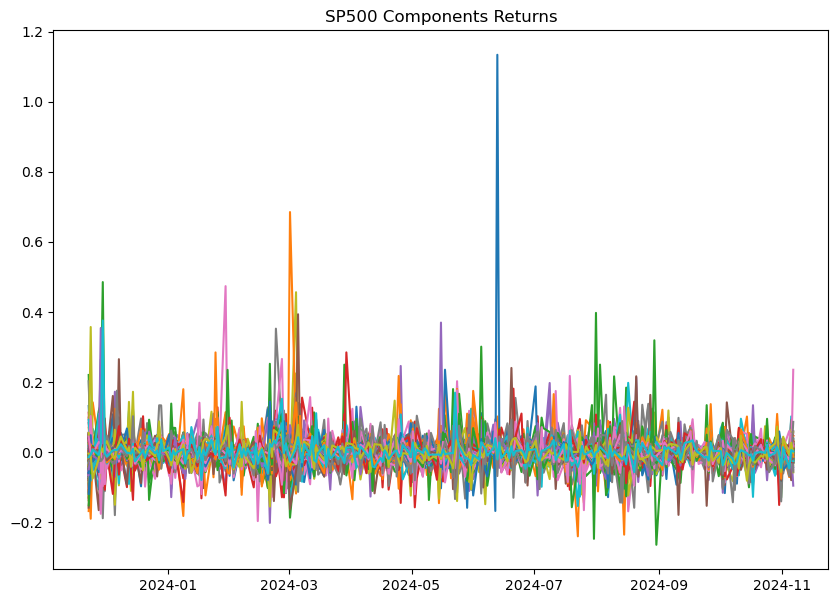

In [7]:
##Cakculating the returns

SP500Ret=DataSP500.pct_change().iloc[1:]
for i in DataSP500: 
    if sum(np.log(1+SP500Ret.replace(np.nan,0)[i]))==0: # Condition that checks the sum of loh returns and tells us if there is any data for that specific ticker
        SP500Ret=SP500Ret.drop(columns=[i])

plt.figure(figsize=(10, 7))
for column in SP500Ret.columns:
    plt.plot(SP500Ret[column], label=column)
# plt.legend(fontsize='small')
plt.title("SP500 Components Returns")
plt.show()

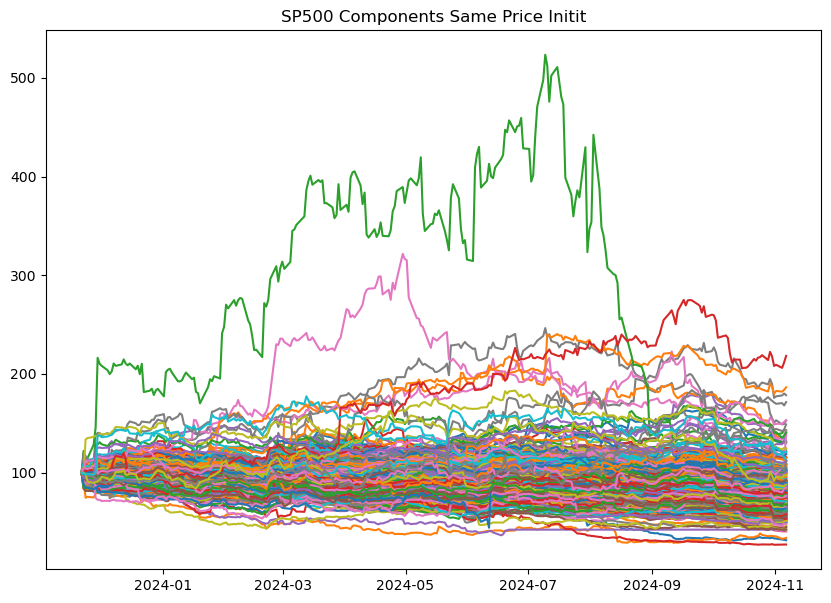

In [8]:
####Price Path over the last year if all stock started by the same point. 

SP500PricePath=pd.DataFrame()

for i in SP500Ret: 
    PricePath=[100]
    for j in range(0,len(SP500Ret[i])):
        PricePath.append(PricePath[j]*(1+SP500Ret[i].iloc[j]))
    SP500PricePath[i]=PricePath
SP500PricePath.index=DataSP500.index

plt.figure(figsize=(10, 7))
for column in SP500PricePath.columns:
    plt.plot(SP500PricePath[column], label=column)
# plt.legend(fontsize='small')
plt.title("SP500 Components Same Price Initit")
plt.show()

In [9]:

Stocks= SP500Ret.columns.tolist()##Portfolio Tickers

### Recursive Hyperparameter Method

ReturnsPort = SP500Ret[Stocks]
cov_matrix = SP500Ret[Stocks].cov()

weights = cp.Variable(len(Stocks))

# Define the objective function (portfolio variance)
portfolio_var = cp.quad_form(weights, cov_matrix)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0
]

# Define the optimization problem
problem = cp.Problem(cp.Minimize(portfolio_var), constraints)

# Solve the problem
problem.solve()

# Extract and print the optimal weights
min_variance_weights = weights.value
print("\nOptimal Weights for Minimum Variance Portfolio:")
Weights = pd.DataFrame(min_variance_weights).transpose()
Weights.columns = Stocks
Weights.index = ["Weights"]
print(Weights)

# Calculate and print the minimum variance
min_variance = portfolio_var.value
print(f"\nMinimum Variance: {min_variance:.6f}")
print(f"\nMinimum Volatility: {np.sqrt(min_variance):.6f}")


Optimal Weights for Minimum Variance Portfolio:
             NVDA      AAPL      MSFT          AMZN      GOOG     GOOGL  \
Weights  0.012241  0.035432  0.001086  1.554199e-07  0.006892  0.020938   

                 META      TSLA          AVGO       LLY  ...          HSIC  \
Weights  8.121130e-09  0.000001  4.694103e-07  0.017865  ... -6.424179e-07   

                  CZR       IVZ       WBA           HII           BWA  \
Weights  5.724957e-07 -0.000001 -0.000001 -5.897928e-07 -1.867068e-07   

                  FMC      PARA          BBWI          QRVO  
Weights  8.538290e-07  0.002087  2.995165e-08 -2.783674e-07  

[1 rows x 500 columns]

Minimum Variance: 0.000013

Minimum Volatility: 0.003588


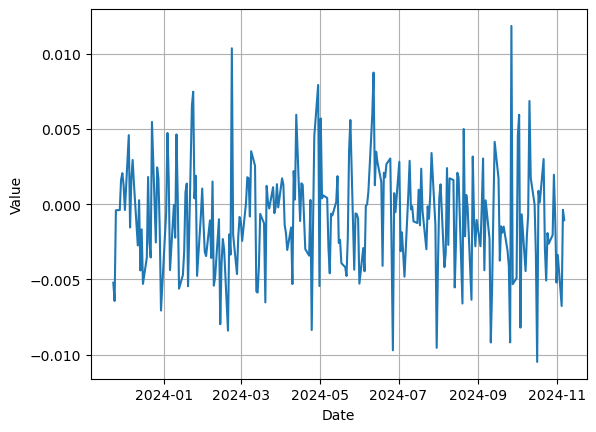

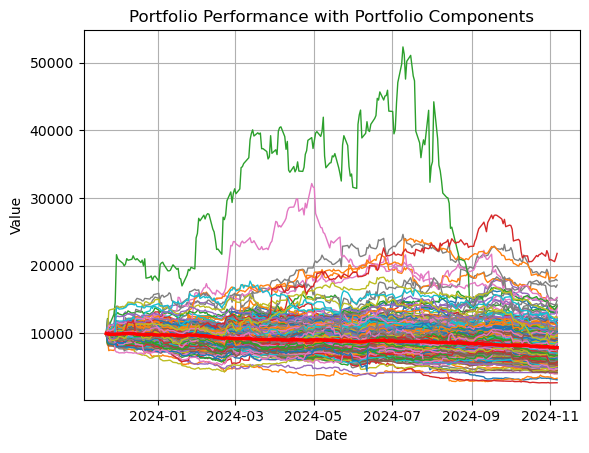

The yearly return on the Minimum Variance Portfolio is: -21.01%
Portfolio dates are: 2023-11-21 to 2024-11-07


In [27]:
ReturnsOptimal=pd.DataFrame(ReturnsPort[i]*float(Weights[i]) for i in Weights)
ReturnsOptimal_Portfolio=ReturnsOptimal.sum()
axx=plt.plot(ReturnsOptimal_Portfolio)
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

PortfolioPerformance=[Value_Invested]
for i in range(0,len(ReturnsOptimal_Portfolio)): 
    PortfolioPerformance.append(PortfolioPerformance[i]*(1+ReturnsOptimal_Portfolio[i]))

PortfolioPerformance=pd.DataFrame(PortfolioPerformance)
    
PortfolioPerformance.index=SP500PricePath.index
PortfolioPerformance.columns=["Portfolio"]

SP500PricePath_Portfolio_D=pd.DataFrame()

for i in Stocks: 
    SP500PricePath_Portfolio=[Value_Invested]
    for j in range(0,len(SP500Ret[i])):
        SP500PricePath_Portfolio.append(SP500PricePath_Portfolio[j]*(1+SP500Ret[i].iloc[j]))
    SP500PricePath_Portfolio_D[i]=SP500PricePath_Portfolio
SP500PricePath_Portfolio_D.index=PortfolioPerformance.index


PortfolioPerformance=pd.concat([SP500PricePath_Portfolio_D,PortfolioPerformance],axis=1)

# Iterate over columns and plot each line
for column in PortfolioPerformance.columns:
    if column == 'Portfolio':  # Specify the column to highlight
        plt.plot(PortfolioPerformance.index, PortfolioPerformance[column], label=column, linewidth=2.5, color='red')  
    else:
        plt.plot(PortfolioPerformance.index, PortfolioPerformance[column], label=column, linewidth=1)  

# Add title and legend
plt.title("Portfolio Performance with Portfolio Components")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)  

# Show the plot
plt.show()
Yearly_Return=np.exp(sum(np.log(1+ReturnsOptimal_Portfolio)))-1

print(f"The yearly return on the Minimum Variance Portfolio is: {round(Yearly_Return * 100, 2)}%")
print("Portfolio dates are:", DataSP500.index[0].date(), "to", today.date())
